# Lockdown intensity through public bikes mobility data

## Table of contents
1. [Introduction](#introduction)
2. [Setup and total variation](#setup)
3. [Analysis of the rides duration](#duration-analysis)
    1. [Detection and removal of outliers](#outliers)
    2. [Distribution of the rides duration](#distribution)
4. [Time series analysis](#time-series)
    1. [Variation during the month](#month)
    2. [Variation by day of the week](#weekday)
    3. [Variation by week](#week)
5. [Conclusions and further work](#conclusions)

## Introduction <a name="introduction"></a>

In this analysis I analyze data on Oslo public bikes during the month of April 2020. The goal is to deduce insights on the biking and overall mobility in that month, and on the intenstity of the lockdown in Oslo.



In general, the harder the lockdown, and the more it is respected by the public, the fewer the people travelling. Therefore it should be possible to assess how strong the restrictions are, and how closely people are following them, by looking at mobility data.

In this analysis I'm going to look at data about the use of the public shared bikes provided by the city of Oslo. I will compare the April 2020 usage data with April 2019 data, which will be my baseline. As a consequence of the lockdown imposed in response to the spread of Covid-19, I expect to see a decrease in the number of travels. I will also try to answer other questions with this analysis
- Is there any trend in the expected decrease along the month? For example, did people pick up bikes more (possibly reaching 2019-like levels) as the month passed by? This could be an indication that the lockdown was eased or less observed by the residents.
    - Is this a day-to-day trend? A week-by-week trend?
- Is there any difference on the expected decrease due to other factors? For example, do factors such as the day of the week, or the type of travel (leisure, commute) play a role?
- Do factors such as public holidays, or the weather play a role?

## Setup and total variation <a name="setup"></a>

I will start from a very simple consideration: the variation of total rides and total rides duration. I will then do a more in-depth analysis, starting with cleaning the data and identifying outliers.

In [1]:
#Pandas and Numpy for data manipulation
import pandas as pd
import numpy as np

#Pyplot and Seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#Collection of function used in the notebook
import april

In [2]:
#Import data
df_19 = pd.read_csv('04-2019.csv',parse_dates=[0,1])
df_20 = pd.read_csv('04-2020.csv',parse_dates=[0,1])
df_19.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2019-04-02 22:18:47.926,2019-04-02 22:24:25.427,337,401,Schous plass,nærmest Thorvald Meyers gate,"59,920259","10,760629",381,Grønlands torg,ved Tøyenbekken,"59,91252","10,76224"
1,2019-04-02 22:25:54.203,2019-04-02 22:27:36.114,101,556,Pilestredet,ved Sporveisgata,"59,9262242","10,7296246",556,Pilestredet,ved Sporveisgata,"59,9262242","10,7296246"
2,2019-04-02 22:26:39.308,2019-04-02 22:31:59.445,320,561,Kirkeveien,nord for Gørbitz' gate,"59,9335582","10,7264261",471,Marienlyst,i Suhms gate,"59,932454","10,721769"
3,2019-04-03 03:09:58.992,2019-04-03 03:12:00.589,121,393,Hans Nielsen Hauges plass,Mellom Åsengata og Nordkappgata,"59,939244","10,774319",393,Hans Nielsen Hauges plass,Mellom Åsengata og Nordkappgata,"59,939244","10,774319"
4,2019-04-03 03:10:02.415,2019-04-03 03:14:44.537,282,597,Fredensborg,ved rundkjøringen,"59,920995","10,750358",557,Akersgata,ved Grensen,"59,9141971","10,7428828"


In [3]:
df_19.dtypes

started_at                   datetime64[ns]
ended_at                     datetime64[ns]
duration                              int64
start_station_id                      int64
start_station_name                   object
start_station_description            object
start_station_latitude               object
start_station_longitude              object
end_station_id                        int64
end_station_name                     object
end_station_description              object
end_station_latitude                 object
end_station_longitude                object
dtype: object

In [4]:
df_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235713 entries, 0 to 235712
Data columns (total 13 columns):
started_at                   235713 non-null datetime64[ns]
ended_at                     235713 non-null datetime64[ns]
duration                     235713 non-null int64
start_station_id             235713 non-null int64
start_station_name           235713 non-null object
start_station_description    235713 non-null object
start_station_latitude       235713 non-null object
start_station_longitude      235713 non-null object
end_station_id               235713 non-null int64
end_station_name             235713 non-null object
end_station_description      235713 non-null object
end_station_latitude         235713 non-null object
end_station_longitude        235713 non-null object
dtypes: datetime64[ns](2), int64(3), object(8)
memory usage: 23.4+ MB


The dataset has no missing values, and the data types correctly represent the data.

In [5]:
#Compute the variation in the number of total rides, note that length of index = number of rides
total_rides_variation = (len(df_20.index) / len(df_19.index)) - 1
print(f"The relative variation in the number of total rides is {total_rides_variation}")

The relative variation in the number of total rides is -0.5019154649934454


Compared to 2019, there have been 50.19% fewer rides in 2020. There is no doubt that the main cause of this stark decrease was the lockdown caused by the Covid-19 pandemic.

## Analysis of the rides duration <a name="duration-analysis"></a>

### Detection and removal of outliers <a name="outliers"></a>

In [6]:
#Durations are in seconds
df_19['duration'].head()

0    337
1    101
2    320
3    121
4    282
Name: duration, dtype: int64

In [7]:
#Compute the variation in the total rides duration, by summing over the "duration" column
total_duration_2019 = df_19['duration'].sum()
total_duration_2020 = df_20['duration'].sum()
total_duration_variation = (total_duration_2020 / total_duration_2019) -1
print(f"The relative variation in the total rides duration is {total_duration_variation}")

The relative variation in the total rides duration is -0.4597291706479003


Compared to 2019, the total time traveled has shrinked by 45.97%. Again, this stark decrease is mainly caused mainly in the lockdown. I'd like to highlight that the total time traveled has decreased less than the total number of rides. Therefore the average duration of a ride has actually increased. Let's then investigate the distribution of the rides durations in the two years.

In [8]:
df_19['duration'].describe()

count    2.357130e+05
mean     8.875432e+02
std      6.237237e+03
min      6.100000e+01
25%      3.300000e+02
50%      5.310000e+02
75%      8.890000e+02
max      1.135407e+06
Name: duration, dtype: float64

The maximum duration is way larger than the 75-th percentile, it is greater by a 10³ factor. This suggests that there are some outliers. Notice that there is no such problem on the lower tail of the duration series, as the minimum is reasonably lower than the 25-th percentile. I now try to investigate this deeper.

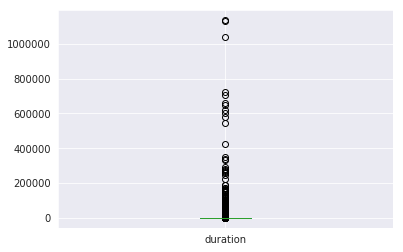

In [9]:
#Box plot showing univariate distribution
df_19['duration'].plot(kind='box');

The box plot appears completely flat, and there are few points way off.

In [10]:
#Select the points way up in the graph
outliers_19 = df_19[df_19['duration'] > 1000000]
outliers_19

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
10673,2019-04-04 15:55:17.918,2019-04-16 17:10:45.381,1041327,574,Annette Thommessens Plass,langs Schweigaards gate,"59,9107393","10,7609998",588,Meltzers gate,ved Skovveien,"59,9180141","10,7184345"
22812,2019-04-06 12:12:32.245,2019-04-19 15:35:59.607,1135407,613,Schives gate,ved Arno Bergs plass,"59,9208044","10,7140544",532,Bryn T-Bane,Ved Østensjøveien,"59,909238","10,814199"
82710,2019-04-13 18:31:33.384,2019-04-26 21:09:08.363,1132654,437,Sentrum Scene,ved Arbeidersamfunnets plass,"59,915484","10,7510765",436,Vestkanttorvet,langs Tidemands gate,"59,9244031","10,7130691"


These three rides have a duration of 12-13 days. This is unusual at best, and likely an indication of some error in the measurement or of some misuse. As these rides are not representative of the standard usage, I drop them.

In [11]:
#Compute new number of rides
df_19 = df_19.drop(outliers_19.index)
len(df_19.index)

235710

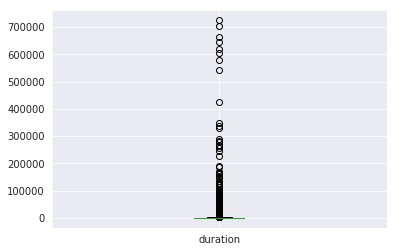

In [12]:
#Updated box plot showing univariate distribution
df_19['duration'].plot(kind='box');

As the box plot is still flat, it is clear that I have to remove further outliers. I will detect outliers using the Z-score, which is the number of standard deviations that a datum is above or below the median. Generally, data with Z-score larger than 3 are considered outliers. 

In [13]:
#Get outliers in the univariate distribution, by using the Z-score
outliers_19 = april.get_zscore_outliers(df_19['duration'])
outliers_19.head()

677      18340
2250     30635
3247     15987
3477    162963
4471     42277
Name: duration, dtype: int64

In [14]:
#Percentage of outliers
100*len(outliers_19.index) / len(df_19.index)

0.14254804632811505

The rows with Z-score strictly greater than 3 account for only 0.14% of the total data. I can safely drop these values, at least for studying the rides duration.

In [15]:
#Drop the outliers
df_19 = df_19.drop(outliers_19.index)
df_19['duration'].describe()

count    235374.000000
mean        775.167644
std         823.462370
min          61.000000
25%         330.000000
50%         531.000000
75%         886.000000
max       15360.000000
Name: duration, dtype: float64

The description of the dataframe looks better now. Let's see how the box plot turns out.

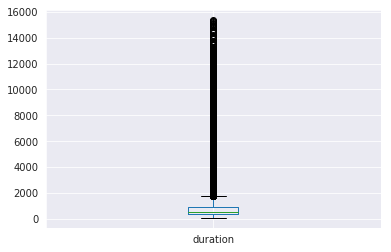

In [16]:
#Final box plot showing univariate distribution without outliers
df_19['duration'].plot(kind='box');

This also looks better. I can now say that we have removed all the outlier records from the 2019 data, in terms of ride duration. This is the only sensible feature to evaluate outliers on, as the other numerical data are station IDs, or geographical coordinates.

I now repeat the same study for the 2020 data.

In [17]:
df_20['duration'].describe()

count    117405.000000
mean        962.715464
std        1283.649437
min          61.000000
25%         384.000000
50%         637.000000
75%        1107.000000
max      183081.000000
Name: duration, dtype: float64

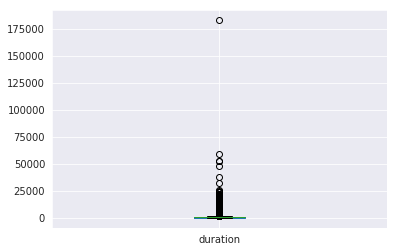

In [18]:
#Box plot showing univariate distribution
df_20['duration'].plot(kind='box');

In [19]:
#Get outliers in the univariate distribution, by using the Z-score
outliers_20 = april.get_zscore_outliers(df_20['duration'])
outliers_20.head()

450     6845
459    12591
546     7921
857     9921
884     5352
Name: duration, dtype: int64

In [20]:
#Percentage of outliers
100*len(outliers_20.index) / len(df_20.index)

0.9897363826072143

Outliers account for less than 1% of the data, so I can safely drop them.

In [21]:
#Drop the outliers
df_20 = df_20.drop(outliers_20.index)
df_20['duration'].describe()

count    116243.000000
mean        886.546519
std         772.094440
min          61.000000
25%         382.000000
50%         631.000000
75%        1085.000000
max        4813.000000
Name: duration, dtype: float64

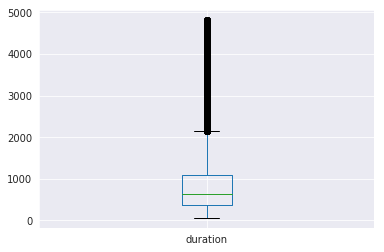

In [22]:
#Final box plot showing univariate distribution without outliers
df_20['duration'].plot(kind='box');

### Distribution of the rides duration <a name="distribution"></a>

Now that I have cleaned my dataframes, I can proceed with a more meaningful study. To start with, let's compare again average duration and total traveled time in the two years.

In [23]:
print(f"Total traveled time in 2019: {df_19['duration'].sum()} seconds. Average traveled time: {df_19['duration'].mean()} seconds.")
print(f"Total traveled time in 2020: {df_20['duration'].sum()} seconds. Average traveled time: {df_20['duration'].mean()} seconds.")

Total traveled time in 2019: 182454309 seconds. Average traveled time: 775.1676438349181 seconds.
Total traveled time in 2020: 103054827 seconds. Average traveled time: 886.5465189301722 seconds.


I confirm that the average time traveled has increased in 2020. Therefore the decrease in total time travelled is caused exclusively by the fewer total rides. Let's compare the distributions.

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


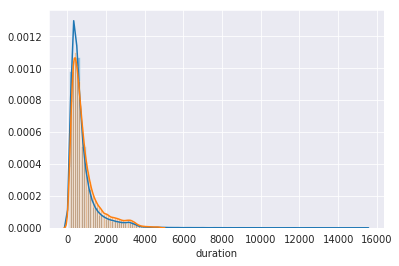

In [24]:
#Plot distribution of the 2019 and 2020 data on rides duration
sns.distplot(df_19['duration']);
sns.distplot(df_20['duration']);

The chart is not very readable, due to the presence of rides with large duration. Let's then focus on the bulk of it:

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


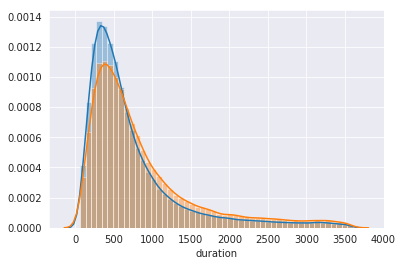

In [25]:
#Filter rides lasting at most 3600 seconds (1 hour, which is the limit for free rides)
rides_filter19 = np.where(df_19['duration']<3600,True,False)
rides_filter20 = np.where(df_20['duration']<3600,True,False)

#Plot distribution of the 2019 and 2020 data on rides duration, for those lasting at most 3600 seconds
sns.distplot(df_19[rides_filter19]['duration']);
sns.distplot(df_20[rides_filter20]['duration']);

What I get from this distribution plot is that in 2020 we had fewer rides that lasted between 0 and about 800 seconds, but more rides lasting more than 800 seconds.

## Time series analysis <a name="time-series"></a>

### Variation during the month <a name="month"></a>

I now study how the number and duration of rides changed during the month in the two considered years. As a first approximation, I am going to ignore the distinction between weekdays and weekends.

In [26]:
#Aggregate the 2019 data by day. Keep track of total rides and total duration
days_19 = april.aggregate_by_day(df_19)
days_19

,Total rides,Total duration,Year
Day,,,
2,3,758,2019
3,5017,3067059,2019
4,8014,5640040,2019
5,7619,5075983,2019
6,6869,5601060,2019
7,4999,4499821,2019
8,7571,4817534,2019
9,8776,5350613,2019
10,9349,5646287,2019


In [27]:
#Aggregate the 2020 data by day. Keep track of total rides and total duration
days_20 = april.aggregate_by_day(df_20)
days_20

,Total rides,Total duration,Year
Day,,,
1,2825,2335024,2020
2,2141,1546751,2020
3,2926,2254184,2020
4,2944,2974345,2020
5,1827,1779061,2020
6,3816,3543888,2020
7,4241,3930040,2020
8,3453,2746289,2020
9,3545,3956230,2020


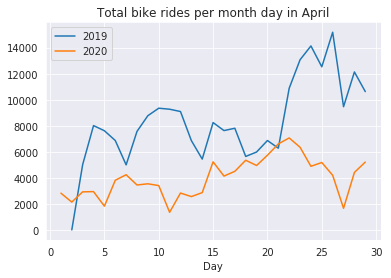

In [28]:
#Plot the 2019 and 2020 data on total rides in April
days_19['Total rides'].plot()
days_20['Total rides'].plot()
plt.legend(['2019','2020'])
plt.title('Total bike rides per month day in April');

Plotting alongside the 2019 and 2020 data, it is clear that almost every day of the month there have been fewer rides in 2020. In particular, the gap narrows towards the 20th of April, and then widens again. This may be due to the fact that week 12-19 was Easter week in 2020, which is unrelated with the lockdown. However, before drawing conclusions I should also account for the weather and for the day of the week.

Let's visualize the relative variation.

In [29]:
#Compute the relative variation in total rides, day by day
df_variations = (days_20['Total rides'] / days_19['Total rides']) -1
df_variations.head()

Day
1           NaN
2    712.666667
3     -0.416783
4     -0.632643
5     -0.760205
Name: Total rides, dtype: float64

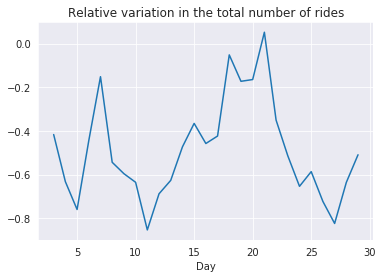

In [30]:
#Plot the relative variation day by day. Data for the 1st and 2nd of April is problematic, so we don't plot it
df_variations.loc[3:].plot(kind='line')
plt.title('Relative variation in the total number of rides');

As seen in the previous chart, the relative variation compared to 2019 has been close to zero around the 20th of April, and near the end of the month it went back to levels similar to the week 5-12.

Let's make the same study for the duration of the rides.

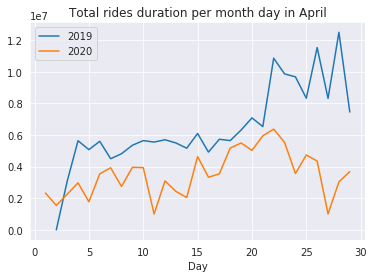

In [31]:
#Plot the 2019 and 2020 data on total duration in April
days_19['Total duration'].plot()
days_20['Total duration'].plot()
plt.legend(['2019','2020'])
plt.title('Total rides duration per month day in April');

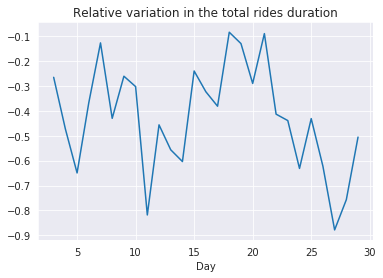

In [32]:
#Compute the relative variation in total duration day by day, and plot it. 
df_variations = (days_20['Total duration'] / days_19['Total duration']) -1
df_variations.loc[3:].plot(kind='line'); #Plot. Data for the 1st and 2nd of April is problematic, so we don't plot it
plt.title('Relative variation in the total rides duration');

The relative variation in total rides duration shows the same behaviour as the relative variation in the total number of rides, albeit less smooth.

This brief study is able to detect a spike in mobility in the period 12th-19th of April, which was Easter week in 2020. This surely denotes the fact that in those days the situation was similar to 2019, so it may hint at an ease of the lockdown, or at a less strict following of the lockdown rules by the population. Even with simple mobility data, we can see a clear increase in mobility to levels similar to 2019.

This first study is not conclusive on the _reasons_ though. I'd be able to investigate more about this by plugging in weather data, the day of the week and the days when restrictions were lifted.

Regarding the overall trend along the month, the study of the total number of rides and their duration tells that there is not any upward trend along the month. Mobility varied, but it increased and decreased during the month. Oslo residents did not use the bikes sensibly more and more as the days passed by.

### Variation by day of the week <a name="weekday"></a>

I now separate the days in weekdays and weekend, to investigate whether there is any difference in the mobility.

In [33]:
#Aggregate the 2019 and 2020 data together by weekday. Keep track of total rides and total duration
df_weekday = april.joint_aggregate_by_weekday(df_19,df_20)
df_weekday

Total rides  Total duration
Year                                     
2019 Weekday       176452       127266247
     Weekend        58922        55188062
2020 Weekday        87598        74435840
     Weekend        28645        28618987

In [34]:
#Compute the relative variation in total rides, distinguishing between weekdays and weekends.
(_vwork,_vend) = (df_weekday.loc[2020,'Total rides'] / df_weekday.loc[2019,'Total rides']) - 1
print(f"The relative variation of total rides on weekdays is {round(_vwork,4)}, on weekends is {round(_vend,4)}.")

The relative variation of total rides on weekdays is -0.5036, on weekends is -0.5138.


,Total rides,Total duration,Average duration
Weekday,-0.503559,-0.415117,0.178152
Weekend,-0.513849,-0.481428,0.066689


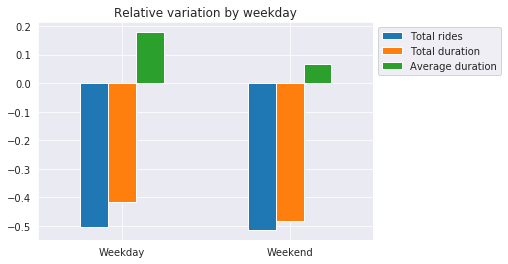

In [35]:
#Compute and plot relative variations of total rides, total duration and average duration
april.plot_rel_variations(df_weekday)

The variation in the total number of rides is the same regardless of whether the considered day is a weekday or a weekend. As seen, the average variation of a ride has increased, and it increased more in the weekdays. Hence the trend "fewer rides, but longer" is more prevalent in the weekdays. Consequently, the total duration has decreased more in the weekends.

Anyway, I do not detect any big difference in the variation between weekdays and weekends, except for the average ride duration.

### Variation by week <a name="week"></a>

I now try to answer the following question: as the weeks passed by, did the people traveled more using the public bikes?

As said at the beginning, if bike usage is to be considered a good proxy for the overall mobility, by answering this question I can understand whether the Oslo residents traveled more/less/the same in general, as the weeks passed by. Therefore, I can try to understand whether the lockdown was progressively eased (or ignored) or not.

In [36]:
#Aggregate the 2019 and 2020 data together by week and weekday. Keep track of total rides and total duration
df_week = april.joint_aggregate_by_week(df_19,df_20)
df_week

Total rides  Total duration
Year Week                                     
2019 14   Weekday        20653        13783840
          Weekend        11868        10100881
     15   Weekday        44062        27067110
          Weekend        12306        10664433
     16   Weekday        35318        28710068
          Weekend        13149        13614152
     17   Weekday        65794        50251380
          Weekend        21599        20808596
     18   Weekday        10625         7453849
2020 14   Weekday         7892         6135959
          Weekend         4771         4753406
     15   Weekday        18462        18115472
          Weekend         4191         4107939
     16   Weekday        19299        16000689
          Weekend        10305        10669316
     17   Weekday        30651        26450991
          Weekend         9378         9088326
     18   Weekday        11294         7732729

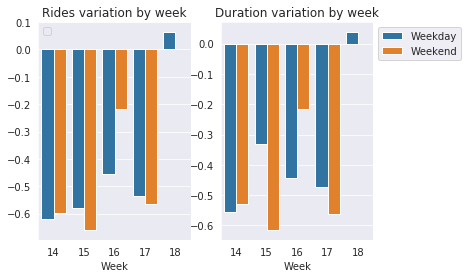

In [37]:
#Compute and plot relative variations of total rides and total duration, keeping also track of the day of the week
april.plot_weekly_var(df_week)

The decrease in the number of rides per week varies a bit, but without following any particular trend. I can say that separating by week did not give any new insight with respect to the division by day, on the trend over time. However, I can make some considerations.

- Week 14 shows the greatest decrease for both quantities.
- There is more variance when comparing weekends than when comparing weekdays. This may be explained by the fact that the work commute is less affected by the lockdown, because its safety does not vary over time. Other factors such as the weather may also play a role, as the weekend traffic is mainly for leisure.
- As seen before, the total number of rides shrinked more that the total time traveled. But actually this is true almost exclusively for the weekdays! Week by week, the decrease in total rides is larger than that in total duration, but that's not true for the weekend.
- In the 16th week there is a great spike in mobility, people seem to have picked up the bikes again, particularly in the weekend! This is worth investigating, the standard suspects are public holidays and weather.

The week ending in the 12th of April 2020 was indeed the week leading up to Easter. This was not the case in 2019, where Easter was the 21st of April. This explains the smaller decrease in the rides taken in that weekend---it was Easter weekend in 2020.

## Conclusions and further work <a name="conclusions"></a>

Except for the increased mobility during the week leading to Easter, about the mobility along the month I can only say that at the beginning of the month people were riding less. However, there is no constant upward trend in the bikes mobility, it continues to vary along April. Drom the data exploration done so far I draw the following conclusion: the decrease in the mobility, particularly in bike mobility, has not varied with any noticeable trend during April 2020 (compared to April 2019), despite being larger at the beginning of the month.

This conclusion is supported by the study of the data by day, by week and by weekday. This suggets that the lockdown has _not_ been progressively ignored (or significantly eased) as weeks passed by.

As already said, this is not definitive: the residents could have in fact going outside more, just not using the public bikes. However, it surely tells something about the usage of bikes to travel.

There are further investigations that could be done on this data: for example, it would be interesting to combine data on bike rides with weather data. This will be included in future versions of this case study.